<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/MNIST_Latent_Space_Flow_Matching_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download/Install Packages

In [1]:
!pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00


In [2]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 8.3 MB/s eta 0:00:00


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from umap import UMAP
from umap.plot import points
import umap

from tensorflow.keras.datasets import mnist

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

# Config

In [7]:
# %matplotlib widget

In [8]:
image_size = 28
sample_size = 20000

In [9]:
def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  x_test = x_test.astype('float32')
  x_test /= 255
  x_test = x_test * 2 - 1
  return x_train, y_train, x_test, y_test

In [10]:
X_train, y_train, X_test, y_test = get_mnist_data()
flat_X_train = X_train[:sample_size].reshape(len(X_train[:sample_size]), -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
pca_umap_pipeline = Pipeline([
    ("PCA", PCA(n_components=40)),
    ("UMAP", UMAP(n_components=2, random_state=42))
])
pca_umap_pipeline = pca_umap_pipeline.fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Preprocessing

In [12]:
reduced_mnist = pca_umap_pipeline.fit_transform(flat_X_train)
reduced_mnist_df = pd.DataFrame(reduced_mnist)

reduced_mnist_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1
0,6.500267,6.396587
1,13.368768,2.101022
2,3.767967,13.605200
3,-1.881207,-2.746832
4,1.144917,11.958029


## Sobel Edge Detection

# Visualizations

## Visualize entire latent space

In [13]:
grid_size = 20

corners = np.array([
    [-3, -3],
    [-3, 15],
    [17, 1],
    [4.5, 15],
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, grid_size)
    for x in np.linspace(0, 1, grid_size)
])

inv_transformed_points = pca_umap_pipeline.inverse_transform(test_pts)

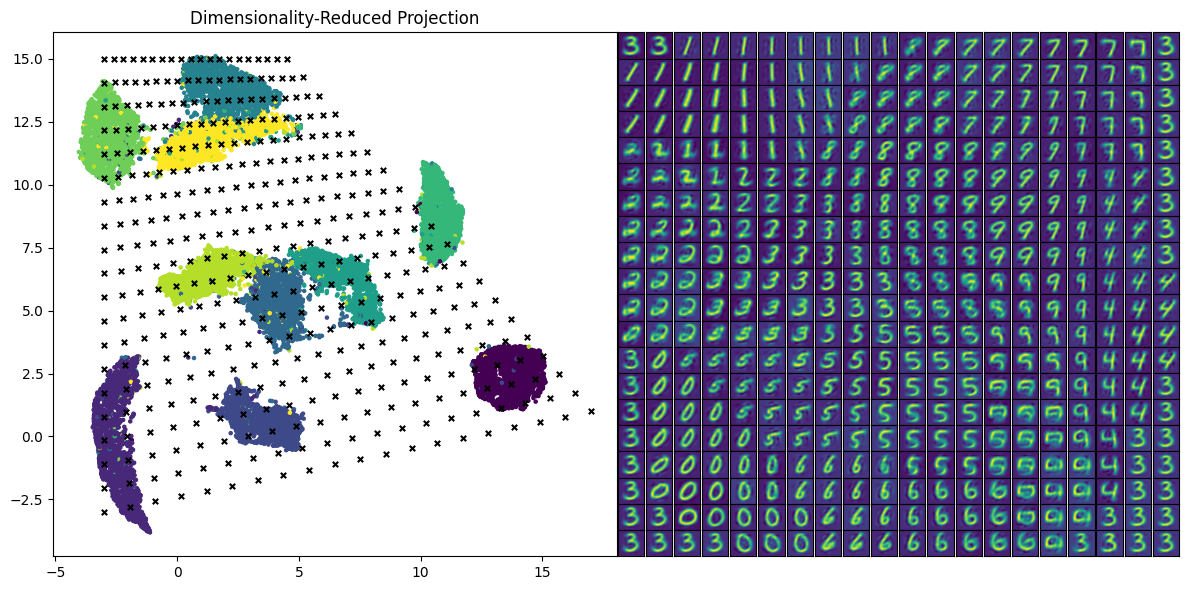

In [14]:
# Set up the grid
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(grid_size, 2 * grid_size, fig)
# Set all padding in GridSpec to 0
gs.update(wspace=0, hspace=0)
scatter_ax = fig.add_subplot(gs[:, :grid_size])
digit_axes = np.zeros((grid_size, grid_size), dtype=object)

for i in range(grid_size):
    for j in range(grid_size):
        digit_axes[i, j] = fig.add_subplot(gs[i, grid_size + j])

# Plot projection onto the scatter axis (use scatter_ax, not plt)
scatter_ax.scatter(
    x=reduced_mnist_df[0],
    y=reduced_mnist_df[1],
    s=5,
    c=y_train[:sample_size]
)
scatter_ax.set_title(f"Dimensionality-Reduced Projection")

# Plot test points
scatter_ax.scatter(
    test_pts[:, 0],
    test_pts[:, 1],
    marker='x',
    c='k',
    s=15
)

# Plot each of the generated digit images
for i in range(grid_size):
    for j in range(grid_size):
        ax = digit_axes[i, j]
        ax.imshow(inv_transformed_points[i * grid_size + j].reshape(28, 28))
        ax.set(xticks=[], yticks=[])

# Show everything at once
plt.tight_layout()
plt.show()

## Visualize a point within the latent space

In [21]:
def get_inv_trans_img(x_pt, y_pt):
  inv_img = pca_umap_pipeline.inverse_transform([[x_pt, y_pt]])[0]
  # inv = (inv - inv.min())/(inv.max() - inv.min() + 1e-8)
  return inv_img.reshape(28, 28)

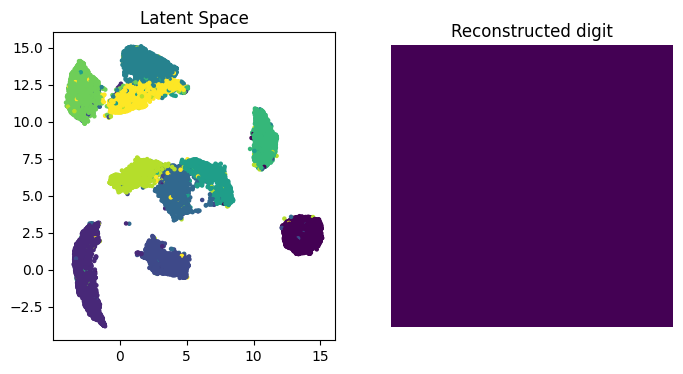

In [16]:
fig, (ax_scatter, ax_img) = plt.subplots(1, 2, figsize=(8, 4))

# scatter in the left panel
scatter = ax_scatter.scatter(
    reduced_mnist_df[0],
    reduced_mnist_df[1],
    s=5,
    c=y_train[:sample_size],
    cmap='viridis'
)
ax_scatter.set_title("Latent Space")

# prepare an empty image in the right panel
img_handle = ax_img.imshow(
    np.zeros((28,28)),
    vmin=0,
    vmax=1
)
ax_img.set_title("Reconstructed digit")
ax_img.axis('off')


def on_click(event):
    print(f"mouse at {event.xdata:.3f}, {event.ydata:.3f}")

    # only care about clicks in the scatter axes with valid data coords
    if event.inaxes is ax_scatter and event.xdata is not None:
        x_pt, y_pt = event.xdata, event.ydata

        # inverse‐transform from latent back to 784‐vector
        print(f"Getting inverse transform for [{round(x_pt, 2)}, {round(y_pt, 2)}], please wait...")
        inv_img = get_inv_trans_img(x_pt, y_pt)
        print("Retrieved inverse transform!")


        # normalize 0→1 so imshow shows contrast
        img_handle.set_data(inv_img)
        ax_img.imshow(inv_img)

        # redraw only the image panel
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [44]:
import random

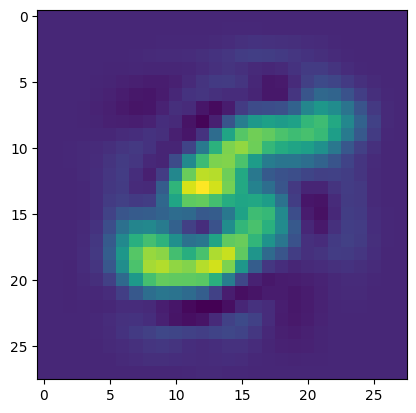

In [47]:
inv_img = pca_umap_pipeline.inverse_transform([[random.random()*17 - 2, random.random()*17 - 2]]).reshape(28, 28)
plt.imshow(inv_img)